# Tweet Sentiment Classification using TweetNLP RoBERTa
This notebook uses the `cardiffnlp/twitter-roberta-base-2021-124m-sentiment` model to classify tweet sentiments as Bearish (0), Neutral (1), or Bullish (2).

---
## Imports
---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

In [1]:
#!pip install -q tweetnlp transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [11]:
import pandas as pd
from sklearn.metrics import classification_report
from tweetnlp import Classifier

# Load TweetNLP RoBERTa sentiment classifier
clf = Classifier("cardiffnlp/twitter-roberta-base-2021-124m-sentiment", max_length=128)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/configuration_auto.py:1138: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

# Preprocess Text
from: https://huggingface.co/cardiffnlp/twitter-roberta-base-2021-124m

Replace usernames and links for placeholders: "@user" and "http".

In [2]:
def preprocess(text):
    tokens = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        tokens.append(t)
    return ' '.join(tokens)

## Load Dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Load train data
train_path = "/content/drive/MyDrive/Project Data/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [13]:
#df = pd.read_csv('train.csv')
train_df['preprocessed_text'] = train_df['text'].apply(preprocess)

In [17]:
train_df['preprocessed_text'].head(10)

,preprocessed_text
0,$BYND - JPMorgan reels in expectations on Beyo...
1,$CCL $RCL - Nomura points to bookings weakness...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ..."
3,$ESS: BTIG Research cuts to Neutral http
4,$FNKO - Funko slides after Piper Jaffray PT cu...
5,$FTI - TechnipFMC downgraded at Berenberg but ...
6,$GM - GM loses a bull http
7,$GM: Deutsche Bank cuts to Hold http
8,$GTT: Cowen cuts to Market Perform
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...


## Predict and Evaluate using TweetNLP model

In [19]:
y_true, y_pred = [], []
label_map = {'Negative': 0, 'Neutral': 2, 'Positive': 1}  # Adjust if needed
for text, label in zip(train_df['preprocessed_text'], train_df['label']):
    result = clf.predict(text)
    # Convert the predicted label from the result dictionary to title case
    # to match the keys in the label_map dictionary.
    pred_label = label_map[result['label'].title()]
    y_true.append(label)
    y_pred.append(pred_label)

print(classification_report(y_true, y_pred, target_names=['Bearish', 'Bullish', 'Neutral']))

              precision    recall  f1-score   support

     Bearish       0.51      0.51      0.51      1442
     Bullish       0.56      0.53      0.55      1923
     Neutral       0.76      0.77      0.77      6178

    accuracy                           0.69      9543
   macro avg       0.61      0.60      0.61      9543
weighted avg       0.68      0.69      0.68      9543



---
## Set the seed for reproducibulity
---

In [20]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

---
## Data split into train and validation
---

In [21]:
# Step 1: Train+Val vs Test (20% for test)
X_temp, X_test, y_temp, y_test = train_test_split(
    train_df["text"], train_df["label"],
    test_size=0.2, stratify=train_df["label"], random_state=42
)

# Step 2: Train vs Val (20% of temp → 16% of full data for val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2, stratify=y_temp, random_state=42
)


---
## Prepare hugging face DatasetDict
---
This stores data splits in an accessible way for other hugging face tools

In [22]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}),
    "validation": Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()}),
    "test": Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
})

---
## Use roberta tokenizer
---

In [23]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64)

tokenized = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

---
## Show an example of a tweet: original and tokenized
---

In [24]:
# Show one example from the training set
sample = tokenized["train"][0]

# Decode the input_ids back into readable text
decoded_text = tokenizer.decode(sample["input_ids"])

# Display nicely
print("Original Text:")
print(dataset["train"][0]["text"])
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])

Original Text:
The world's largest oil producers are hammering out the terms of an unprecedented deal to mitigate the devastating… https://t.co/EvGJKB2l9a

Tokenized Input IDs:
[0, 133, 232, 18, 1154, 681, 4426, 32, 13547, 154, 66, 5, 1110, 9, 41, 7071, 432, 7, 15292, 5, 7360, 1174, 1205, 640, 90, 4, 876, 73, 25377, 534, 863, 36640, 176, 462, 466, 102, 2]

Decoded (Recovered) Text:
<s>The world's largest oil producers are hammering out the terms of an unprecedented deal to mitigate the devastating… https://t.co/EvGJKB2l9a</s>

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
2


---
## Dynamic padding collator
---
Data collators are objects that will form a batch by using a list of dataset elements as input

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
## Compute metrics
---

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

---
## Training arguments
---

In [27]:
training_args = TrainingArguments(
    output_dir="./results/roberta_full",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_full",
    report_to="none"
)

---
## Load model and trainer
---

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-50a046e45707>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


---
## Train the model
---

In [29]:
trainer.train()

Step,Training Loss
500,0.539600
1000,0.376400
1500,0.327100
2000,0.205900


TrainOutput(global_step=2292, training_loss=0.34360512805026655, metrics={'train_runtime': 384.4553, 'train_samples_per_second': 47.654, 'train_steps_per_second': 5.962, 'total_flos': 442776201097734.0, 'train_loss': 0.34360512805026655, 'epoch': 3.0})

---
## Evaluate on validation
---

In [30]:
preds = trainer.predict(tokenized["validation"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(tokenized["validation"]["label"])
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       231
           1       0.81      0.85      0.83       308
           2       0.93      0.91      0.92       988

    accuracy                           0.89      1527
   macro avg       0.85      0.87      0.86      1527
weighted avg       0.89      0.89      0.89      1527



---
## Evaluate on test
---

In [31]:
preds = trainer.predict(tokenized["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(tokenized["test"]["label"])

# Print classification report
report = classification_report(y_true, y_pred, digits=4)
print("Test Set Classification Report:\n")
print(report)

Test Set Classification Report:

              precision    recall  f1-score   support

           0     0.7656    0.8507    0.8059       288
           1     0.8351    0.8416    0.8383       385
           2     0.9292    0.9029    0.9159      1236

    accuracy                         0.8827      1909
   macro avg     0.8433    0.8651    0.8534      1909
weighted avg     0.8856    0.8827    0.8836      1909



---
## Confusion Matrix
---

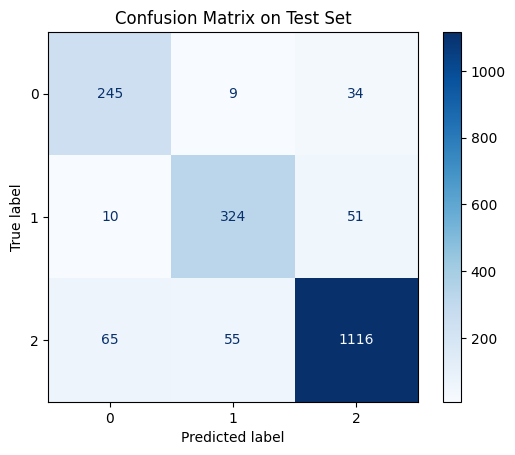

In [32]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()